영상을 입력해서 이진분류할 수 있는 모델들에 대해서 알아보겠습니다. 숫자 손글씨 데이터셋인 MNIST을 이용하여 홀수/짝수를 구분을 위한 데이터셋을 생성해보고,  다층퍼셉트론 및 컨볼루션 신경망 모델을 구성하고 학습 시켜보겠습니다. 이 모델은 임의의 영상으로부터 A와 B를 구분하는 문제나 양성과 음성을 구분하는 문제를 풀 수 있습니다. 아래 문제들에 활용 용 기대해봅니다.
* 입력된 얼굴 사진에 남자인지 여자인지 구분
* 촬영된 부품 사진이 정상인지 불량인지 구분
* 의료영상을 보고 질병유무 판독

---
### 데이터셋 준비

케라스 함수에서 제공하는 숫자 손글씨 데이터셋인 MNIST을 이용하겠습니다. 초기 라벨값은 0에서 9까지 정수로 지정되어 있습니다. 데이터 정규화를 위해서 255.0으로 나누었습니다. 아래는 다층퍼셉트론 신경망 모델에 입력하기 위해 데이터셋 생성하는 코드입니다.

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, width*height).astype('float32') / 255.0
x_test = x_test.reshape(10000, width*height).astype('float32') / 255.0

아래는 컨볼루션 신경망 모델에 입력하기 위해 데이터셋 생성하는 코드입니다. 샘플수, 너비, 높이, 채널수로 총 4차원 배열로 구성합니다.

In [6]:
x_train = x_train.reshape(60000, width, height, 1).astype('float32') / 255.0
x_test = x_test.reshape(10000, width, height, 1).astype('float32') / 255.0

불러온 훈련셋을 다시 훈련셋 50,000개와 검증셋 10,000개로 나누었습니다.

In [7]:
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

라벨값은 다중클래스 분류로 0에서 9까지 지정되어 있으나 이것을 홀수/짝수로 바꾸어서 이진분류 라벨로 지정하겠습니다. '1'은 홀수를 의미하고, '0'은 짝수를 의미합니다.

In [8]:
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

만든 데이터셋 일부를 가시화 해보겠습니다.

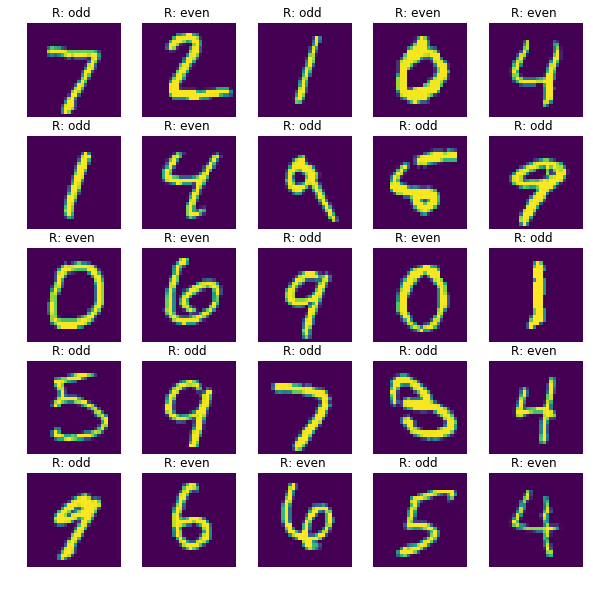

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    
    sub_plt_title = 'R: '
    
    if y_test[i] :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '
    
    sub_plt.set_title(sub_plt_title)

plt.show()

![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_11_0.png)

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록은 'Dropout'입니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Dropout_1D_s.png)|Dropout|과적합을 방지하기 위해서 학습 시에 지정된 비율만큼 임의의 입력 뉴런(1차원)을 제외시킵니다.|
|![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Dropout_2D_s.png)|Dropout|과적합을 방지하기 위해서 학습 시에 지정된 비율만큼 임의의 입력 뉴런(2차원)을 제외시킵니다.|

---
### 모델 준비

영상을 입력하여 이진분류를 하기 위해 `다층퍼셉트론 신경망 모델`, `컨볼루션 신경망 모델`, `깊은 컨볼루션 신경망 모델`을 준비했습니다.

#### 다층퍼셉트론 신경망 모델

    model = Sequential()
    model.add(Dense(256, input_dim=width*height, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_0m.png)

#### 컨볼루션 신경망 모델

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_1m.png)

#### 깊은 컨볼루션 신경망 모델

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_2m.png)    

---
### 전체 소스

앞서 살펴본 `다층퍼셉트론 신경망 모델`, `컨볼루션 신경망 모델`, `깊은 컨볼루션 신경망 모델`의 전체 소스는 다음과 같습니다. 

#### 다중퍼셉트론 신경망 모델

Using TensorFlow backend.


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 5s - loss: 0.2916 - acc: 0.8838 - val_loss: 0.1549 - val_acc: 0.9434
Epoch 2/30
50000/50000 [==============================] - 4s - loss: 0.1247 - acc: 0.9566 - val_loss: 0.0959 - val_acc: 0.9679
Epoch 3/30
50000/50000 [==============================] - 5s - loss: 0.0884 - acc: 0.9697 - val_loss: 0.0871 - val_acc: 0.9718
Epoch 4/30
50000/50000 [==============================] - 4s - loss: 0.0710 - acc: 0.9748 - val_loss: 0.0708 - val_acc: 0.9755
Epoch 5/30
50000/50000 [==============================] - 5s - loss: 0.0591 - acc: 0.9792 - val_loss: 0.0719 - val_acc: 0.9751
Epoch 6/30
50000/50000 [==============================] - 4s - loss: 0.0510 - acc: 0.9826 - val_loss: 0.0793 - val_acc: 0.9738
Epoch 7/30
50000/50000 [==============================] - 5s - loss: 0.0437 - acc: 0.9854 - val_loss: 0.0756 - val_acc: 0.9758
Epoch 8/30
50000/50000 [==============================] - 4s 

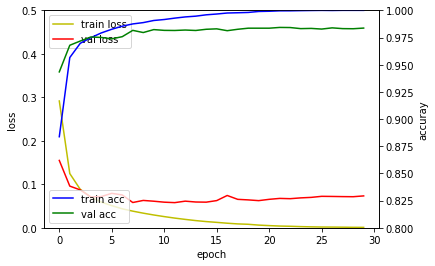

 9664/10000 [===========================>..] - ETA: 0s## evaluation loss and_metrics ##
[0.054539599350485697, 0.98660000000000003]


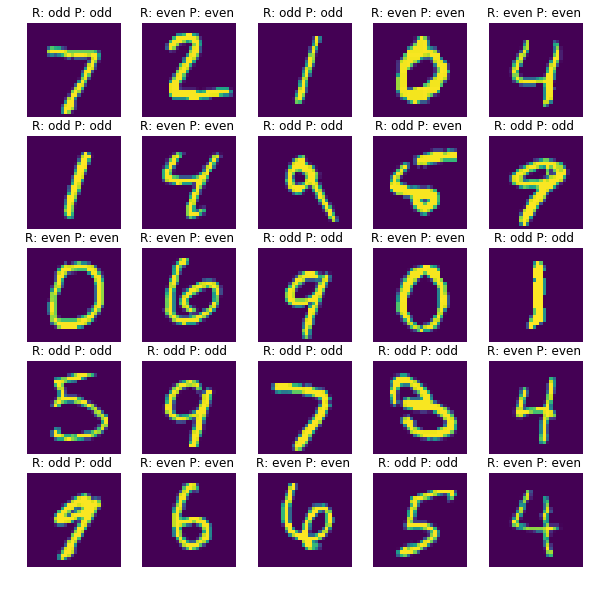

In [1]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation

width = 28
height = 28

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, width*height).astype('float32') / 255.0
x_test = x_test.reshape(10000, width*height).astype('float32') / 255.0

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리 : 홀수는 1, 짝수는 0으로 변환
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(256, input_dim=width*height, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.8, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    
    sub_plt_title = 'R: '
    
    if y_test[i] :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '

    sub_plt_title += 'P: '
    
    if yhat_test[i] >= 0.5 :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '        
    
    sub_plt.set_title(sub_plt_title)

plt.show()

시험셋으로 예측한 결과 일부를 비교해봤습니다. 25개 샘플 중 9번째 샘플을 제외하고는 모두 맞췄습니다. 

![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_16_4.png)

#### 컨볼루션 신경망 모델

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 21s - loss: 0.3355 - acc: 0.8635 - val_loss: 0.1881 - val_acc: 0.9314
Epoch 2/30
50000/50000 [==============================] - 23s - loss: 0.1310 - acc: 0.9528 - val_loss: 0.0873 - val_acc: 0.9705
Epoch 3/30
50000/50000 [==============================] - 21s - loss: 0.0929 - acc: 0.9669 - val_loss: 0.0700 - val_acc: 0.9758
Epoch 4/30
50000/50000 [==============================] - 21s - loss: 0.0737 - acc: 0.9739 - val_loss: 0.0585 - val_acc: 0.9796
Epoch 5/30
50000/50000 [==============================] - 22s - loss: 0.0626 - acc: 0.9779 - val_loss: 0.0531 - val_acc: 0.9810
Epoch 6/30
50000/50000 [==============================] - 21s - loss: 0.0546 - acc: 0.9810 - val_loss: 0.0496 - val_acc: 0.9829
Epoch 7/30
50000/50000 [==============================] - 21s - loss: 0.0495 - acc: 0.9830 - val_loss: 0.0451 - val_acc: 0.9838
Epoch 8/30
50000/50000 [==============================

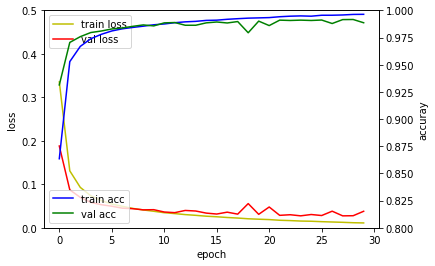

 9728/10000 [============================>.] - ETA: 0s## evaluation loss and_metrics ##
[0.033111137489188695, 0.98819999999999997]


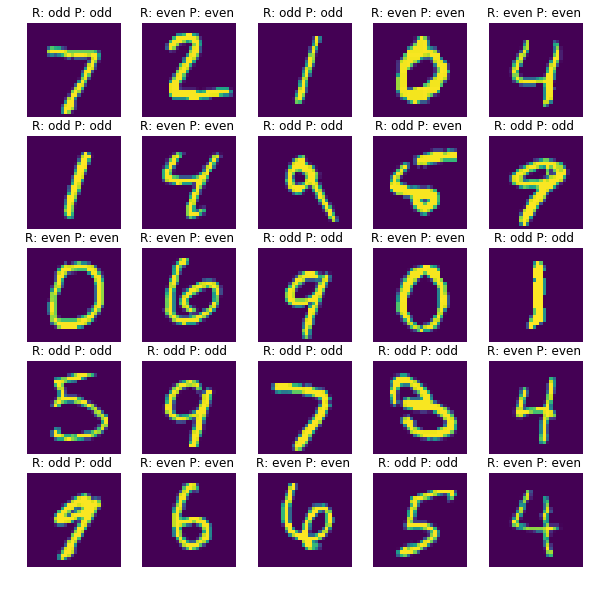

In [2]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten

width = 28
height = 28

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, width, height, 1).astype('float32') / 255.0
x_test = x_test.reshape(10000, width, height, 1).astype('float32') / 255.0

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리 : 홀수는 1, 짝수는 0으로 변환
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.8, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    
    sub_plt_title = 'R: '
    
    if y_test[i] :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '

    sub_plt_title += 'P: '
    
    if yhat_test[i] >= 0.5 :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '        
    
    sub_plt.set_title(sub_plt_title)

plt.show()

시험셋으로 예측한 결과 일부를 비교해봤습니다. '다층퍼셉트론 신경망 모델'과 마찬가지로 25개 샘플 중 9번째 샘플을 제외하고는 모두 맞췄습니다. 

![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_18_3.png)

#### 깊은 컨볼루션 신경망 모델

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 92s - loss: 0.4378 - acc: 0.7928 - val_loss: 0.1836 - val_acc: 0.9340
Epoch 2/30
50000/50000 [==============================] - 91s - loss: 0.1907 - acc: 0.9273 - val_loss: 0.0861 - val_acc: 0.9702
Epoch 3/30
50000/50000 [==============================] - 91s - loss: 0.1234 - acc: 0.9556 - val_loss: 0.0638 - val_acc: 0.9768
Epoch 4/30
50000/50000 [==============================] - 89s - loss: 0.0948 - acc: 0.9665 - val_loss: 0.0511 - val_acc: 0.9811
Epoch 5/30
50000/50000 [==============================] - 91s - loss: 0.0786 - acc: 0.9725 - val_loss: 0.0453 - val_acc: 0.9834
Epoch 6/30
50000/50000 [==============================] - 93s - loss: 0.0689 - acc: 0.9755 - val_loss: 0.0442 - val_acc: 0.9854
Epoch 7/30
50000/50000 [==============================] - 91s - loss: 0.0624 - acc: 0.9781 - val_loss: 0.0371 - val_acc: 0.9867
Epoch 8/30
50000/50000 [==============================

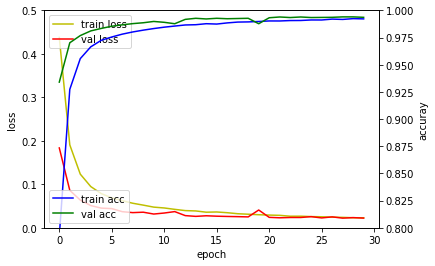

10000/10000 [==============================] - 9s     
## evaluation loss and_metrics ##
[0.012519296416157158, 0.99619999999999997]


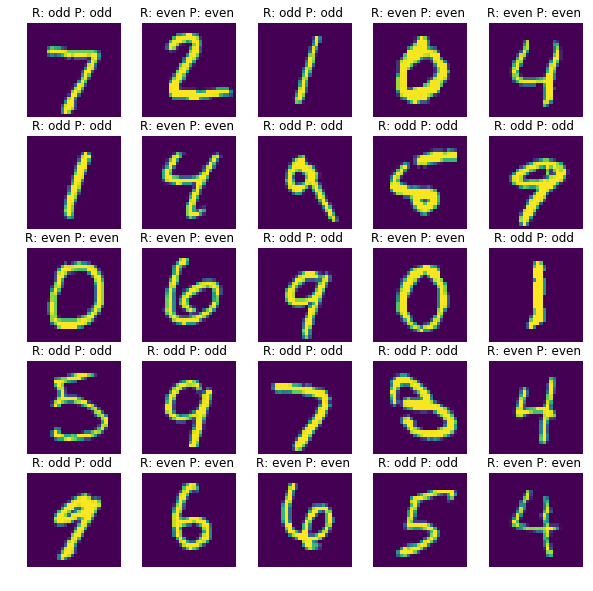

In [3]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dropout

width = 28
height = 28

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, width, height, 1).astype('float32') / 255.0
x_test = x_test.reshape(10000, width, height, 1).astype('float32') / 255.0

# 훈련셋과 검증셋 분리
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

# 데이터셋 전처리 : 홀수는 1, 짝수는 0으로 변환
y_train = y_train % 2
y_val = y_val % 2
y_test = y_test % 2

# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.8, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    
    sub_plt_title = 'R: '
    
    if y_test[i] :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '

    sub_plt_title += 'P: '
    
    if yhat_test[i] >= 0.5 :
        sub_plt_title += 'odd '
    else:
        sub_plt_title += 'even '        
    
    sub_plt.set_title(sub_plt_title)

plt.show()

시험셋으로 예측한 결과 일부를 비교해봤습니다. 이전 모델에선 틀렸던 9번째 샘플도 맞췄습니다.

![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_20_3.png)

---

### 학습결과 비교

다층퍼셉트론 신경망 모델은 훈련정확도는 검증 손실값은 높아지고 있어 과적합이 발생하였습니다. 컨볼루션 신경망 모델은 다층퍼셉트론 신경망 모델에 비해 높은 성능을 보이고 있습니다. 깊은 컨볼루션 신경망 모델은 드랍아웃(Dropout) 레이어 덕분에 과적합이 발생하지 않고 검증 손실값이 지속적으로 떨어지고 있음을 확인할 수 있습니다.

|다층퍼셉트론 신경망 모델|컨볼루션 신경망 모델|깊은 컨볼루션 신경망 모델|
|:-:|:-:|:-:|
|![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_16_2.png)|![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_18_1.png)|![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_output_20_1.png)

---

### 요약

영상를 입력하여 이진분류하는 다층퍼셉트론 신경망 모델, 컨볼루션 신경망 모델, 깊은 컨볼루션 신경망 모델을 살펴보고 그 성능을 확인 해봤습니다.

![img](http://tykimos.github.io/warehouse/2017-8-18-Image_Input_Binary_Classification_Model_Recipe_title_m.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [영상입력 수치예측 모델 레시피](https://tykimos.github.io/Keras/2017/08/20/Image_Input_Numerical_Prediction_Model_Recipe/)    
* 다음 : [영상입력 다중클래스분류 모델 레시피](https://tykimos.github.io/Keras/2017/08/18/Image_Input_Multiclass_Classification_Model_Recipe/)